# Air Quality Foreasting ($CO_2$ emissions) 
## **Business Objective:**
## To forecast $CO_2$ levels for an organization so that the organization can follow government norms with respects to $CO_2$ emission levels.
### Prepare a ppt for each step taken like EDA, Feature Engineering, Model Building,  Model Evaluation and Predicition table, and Deployment. Explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## Model Building Phase On Raw data

### Importing the libraries required

In [1]:
# Importing 
# Libraries
import dtale

import warnings
import itertools
%matplotlib inline
import numpy as np
import pandas as pd

from math import sqrt
import seaborn as sns

import missingno as mn
import plotly.io as pio
sns.set_style('darkgrid')

from pandas import Grouper
import scipy.stats as stat
import plotly.express as px
from pandas import DataFrame

import statsmodels.api as smf
import pandas_profiling as pp
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm
from plotly.offline import plot as off
from plotly.subplots import make_subplots

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.feature_selection import SelectKBest
from pandas_visual_analysis import VisualAnalysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Importing Original Dataset from EDA
Link for the repository -

In [3]:
data=pd.read_excel('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/CO2 dataset.xlsx'\
                   ,index_col='Year',parse_dates=True)

In [4]:
#data.set_index('Year', inplace=True)
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
data.head()

,CO2
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [136]:
data.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


### Splitting Train and Test Data on Original data 

#### Leaving Test Data with 20 Years of Time Series
+ **Training Data** = Fit the model only to training period. 
+ **Testing Data** = Assess the model performance on Testing. 
+ **Deploy model by training on whole dataset. No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.**

In [6]:
size = -20
train_data = data[:size]
test_data = data[size:]

In [14]:
print(test_data.describe(),'\n','Variance ={}'.format(test_data.var()[0]))

             CO2
count  21.000000
mean   16.342857
std     0.850630
min    14.700000
25%    15.700000
50%    16.600000
75%    16.900000
max    17.500000 
 Variance =0.7235714285714288


In [54]:
17.5-14.7

2.8000000000000007

In [6]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1800-01-01 00:00:00 1994-01-01 00:00:00 
 Test: 1995-01-01 00:00:00 2014-01-01 00:00:00


### We are going to forecast for the last 20 years. that is from 1994 to 2014.

##### Last 20 records contain data from 1994 to 2014 data.

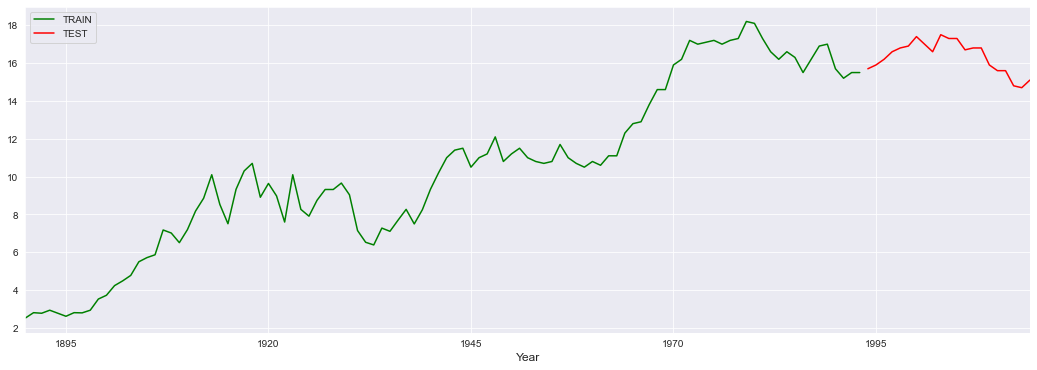

In [40]:
train_data.CO2.plot(legend=True,label='TRAIN',color='green')
test_data.CO2.plot(legend=True,label='TEST', figsize=(18,6),color='red')
plt.xlabel('Year', fontsize= 12)
plt.legend()
plt.show()

In [6]:
%matplotlib inline

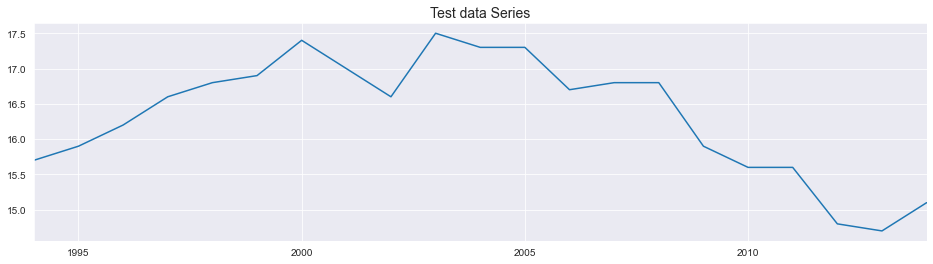

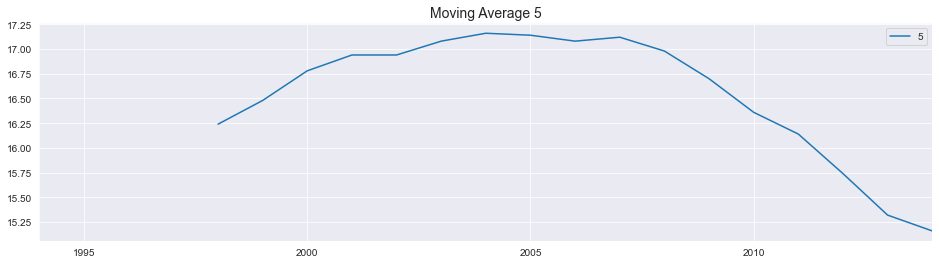

In [11]:
plt.figure(figsize=(16,4))
test_data.CO2.plot(label="org")
plt.title("Test data Series", fontsize=14)
plt.figure(figsize=(16,4))
test_data["CO2"].rolling(5).mean().plot(label=str(5))
plt.title("Moving Average "+str(5), fontsize=14)
plt.legend(loc='best')
plt.show()

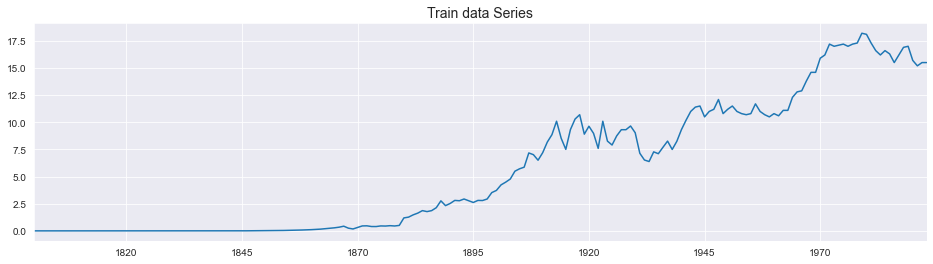

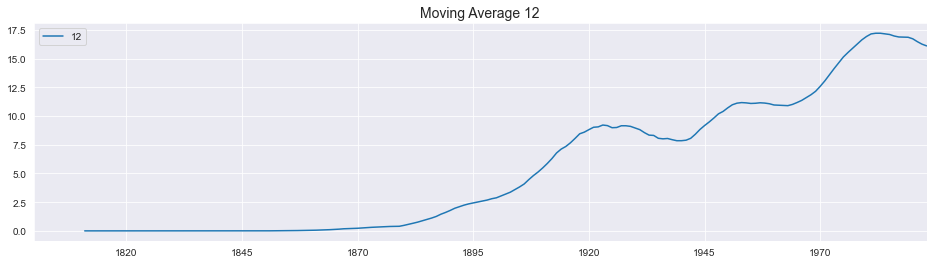

In [12]:
plt.figure(figsize=(16,4))
train_data.CO2.plot(label="org")
plt.title("Train data Series", fontsize=14)
plt.figure(figsize=(16,4))
train_data["CO2"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12), fontsize=14)
plt.legend(loc='best')
plt.show()

### Evaluation Metric MAPE

In [7]:
def MAPE(pred,org):
    temp = np.mean(np.abs((org-pred)/org))*100
    return temp

## Model Building

___
## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [8]:
ses_model = SimpleExpSmoothing(train_data['CO2']).fit(optimized=True)
test_pred_ses = ses_model.forecast(20)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.CO2))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 5.690676732498492 
 Train Root Mean Squared Error = 0.5608911704560209 
 Test Root Mean Squared Error = 1.0791816790615678


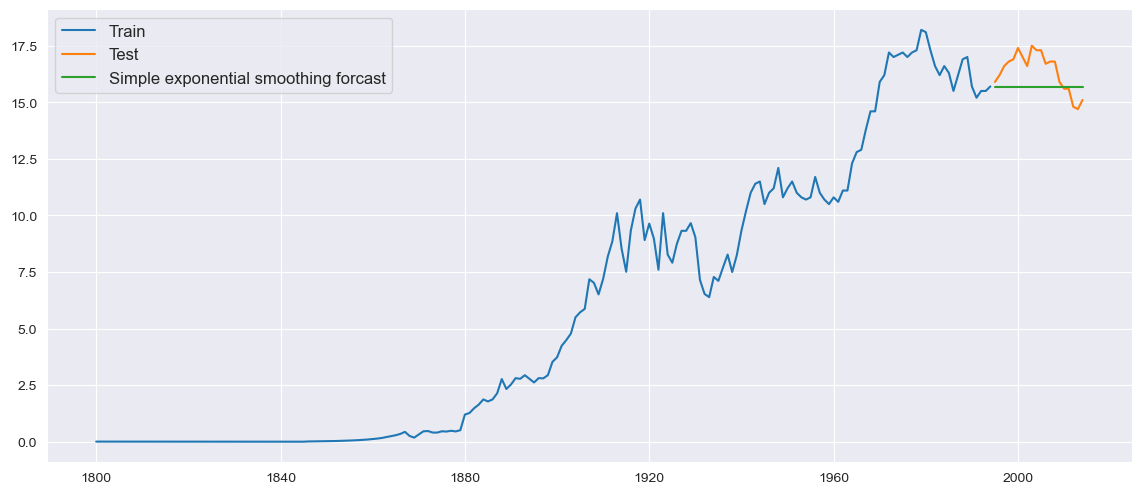

In [11]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. **This method doesn't captures seasonality.**

---
### Holt method (Double Exponential) 

##### Captures both Level and Trend .

In [9]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(20)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = np.sqrt(mean_squared_error(test_pred_dexp,test_data))
train_rmse_dexp = np.sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 5.862070349246654 
 Train Root Mean Squared Error = 0.5545550708210062 
 Test Root Mean Squared Error = 1.1867275501597345


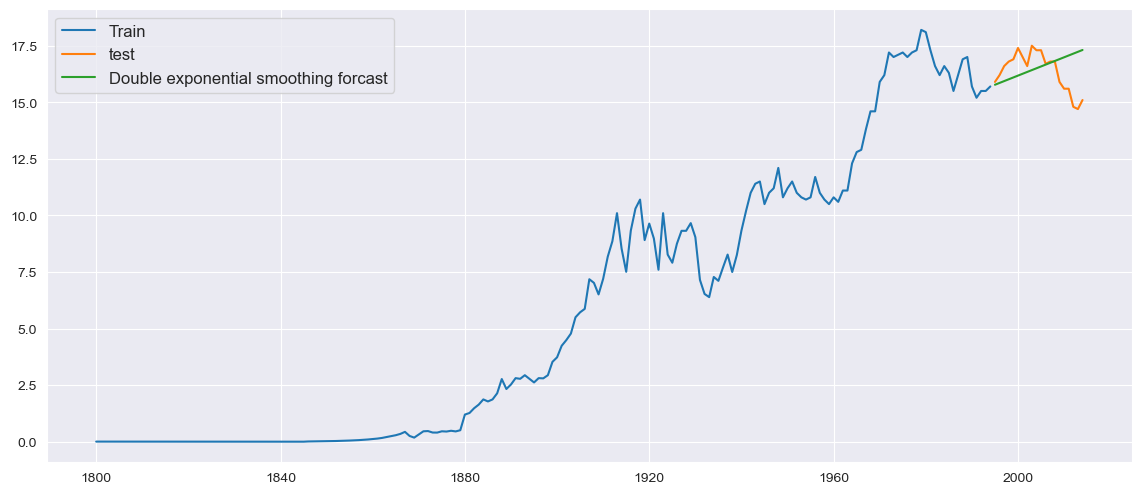

In [13]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [10]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(20)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.CO2)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 5.844242934098549 
 Train Root Mean Squared Error = 0.5332098368925428 
 Test Root Mean Squared Error = 1.2810229605937429


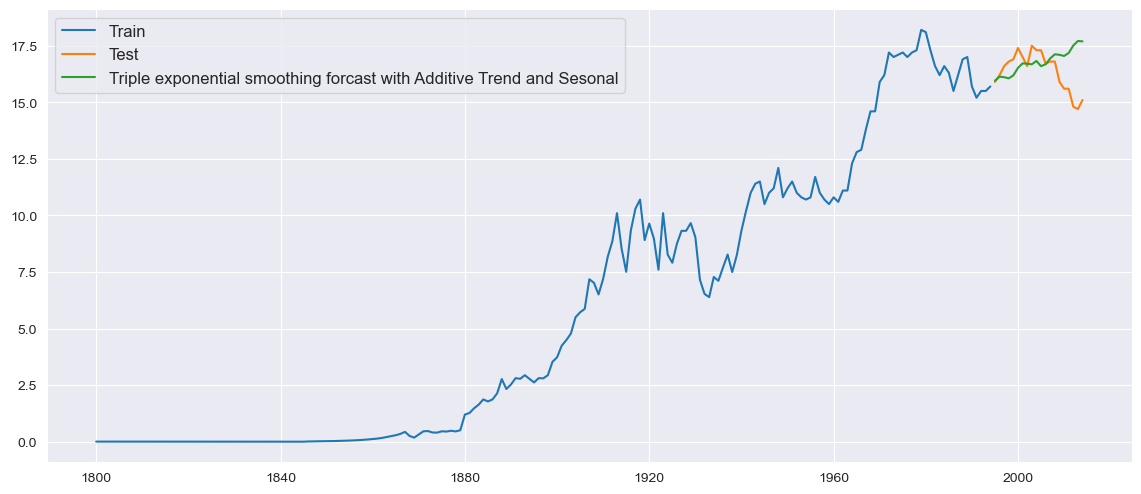

In [15]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. It captures the trend, but which we can see that the forecasted values are higher level than the test level.
2. It doesn't captures the seasonality.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [11]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(20)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.CO2))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.CO2)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 6.331100191998569 
 Train Root Mean Squared Error = 0.5239589471045021 
 Test Root Mean Squared Error = 1.4148657456045628


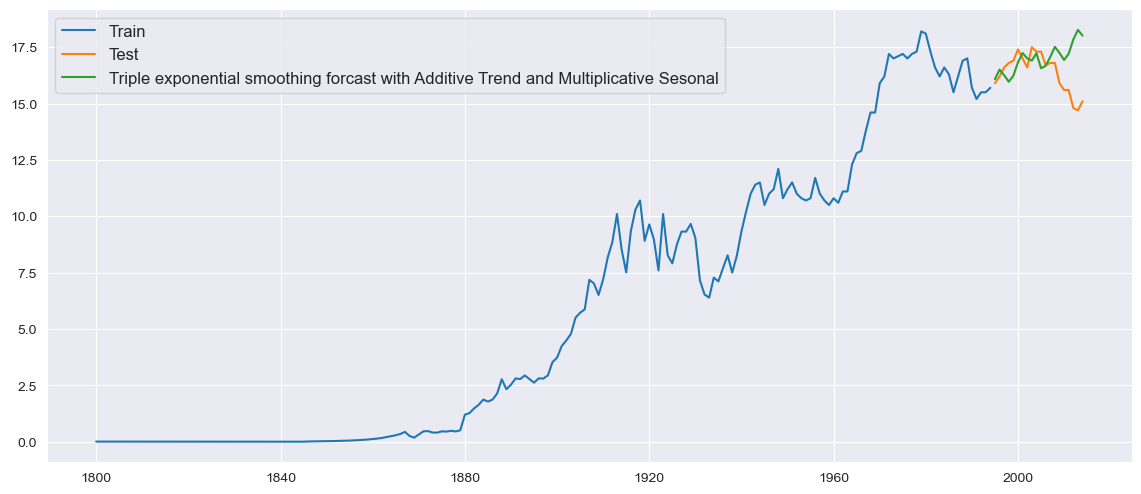

In [17]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that the errors have not reduced, we are not able to capture the seasonality.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [12]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(20)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.CO2))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.CO2)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 80.68765621568603 
 Train Root Mean Squared Error = 3.7930309703653093 
 Test Root Mean Squared Error = 13.653019021596155


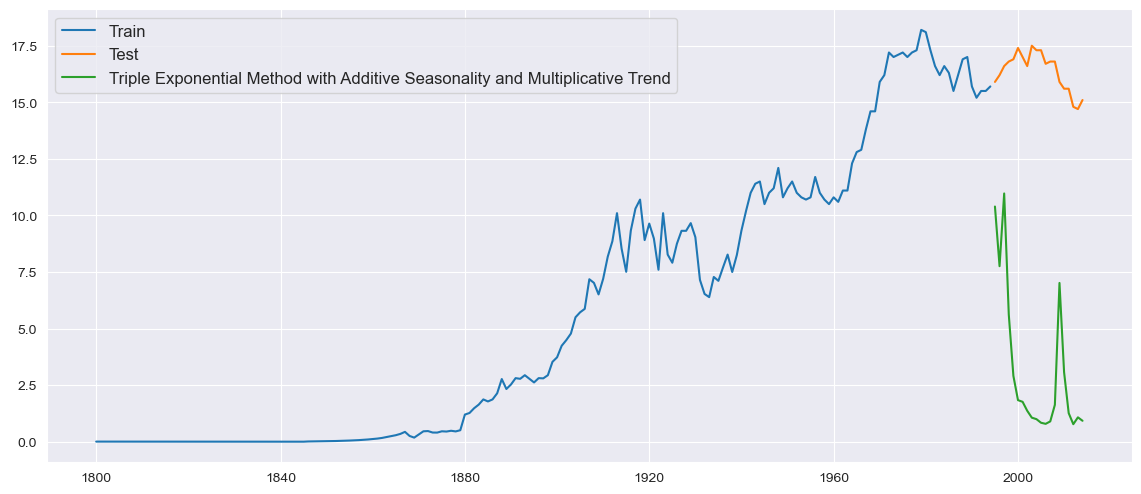

In [23]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best', fontsize=12)
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [13]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(20)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.CO2))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.CO2)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 8.772540917170229 
 Train Root Mean Squared Error = 0.5275325845470183 
 Test Root Mean Squared Error = 1.9728905724687658


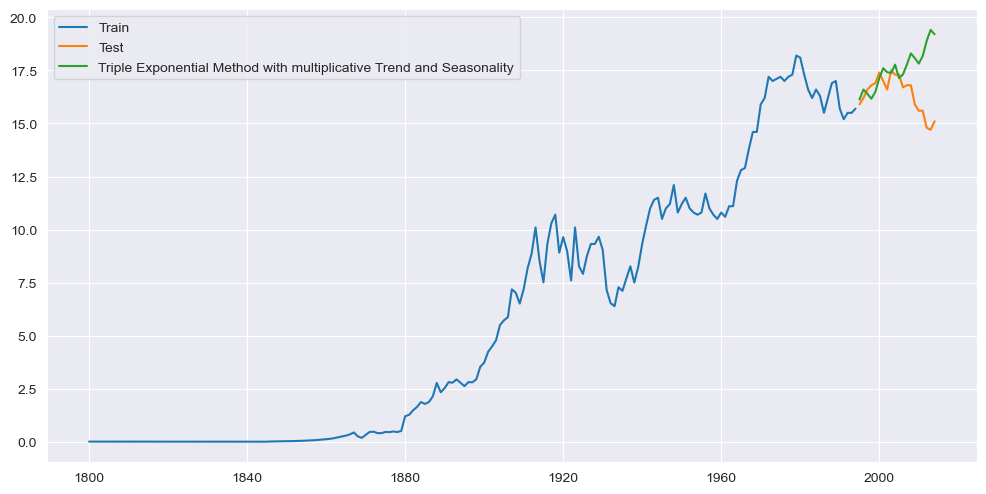

In [25]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

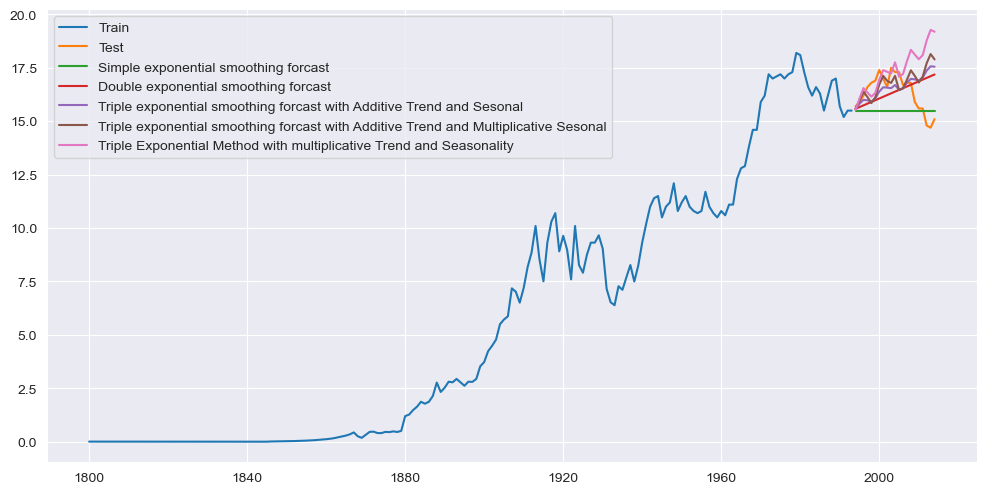

In [29]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

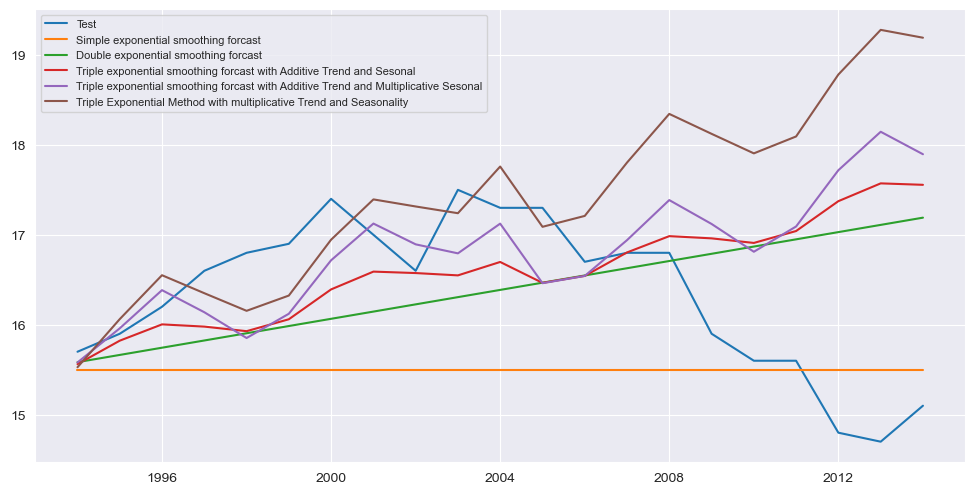

In [30]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best', fontsize=8)
plt.show()

In [14]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Simple_Exp,0.560891,5.690677,1.079182
1,Double_Exp,0.554555,5.862070,1.186728
2,Triple_Exp_ad,0.533210,5.844243,1.281023
3,Triple_Exp_mul_ad,0.523959,6.331100,1.414866
4,Triple_Exp_mul,0.527533,8.772541,1.972891
5,Triple_Exp_ad_mul,3.793031,80.687656,13.653019


### Visualizing Models Performance

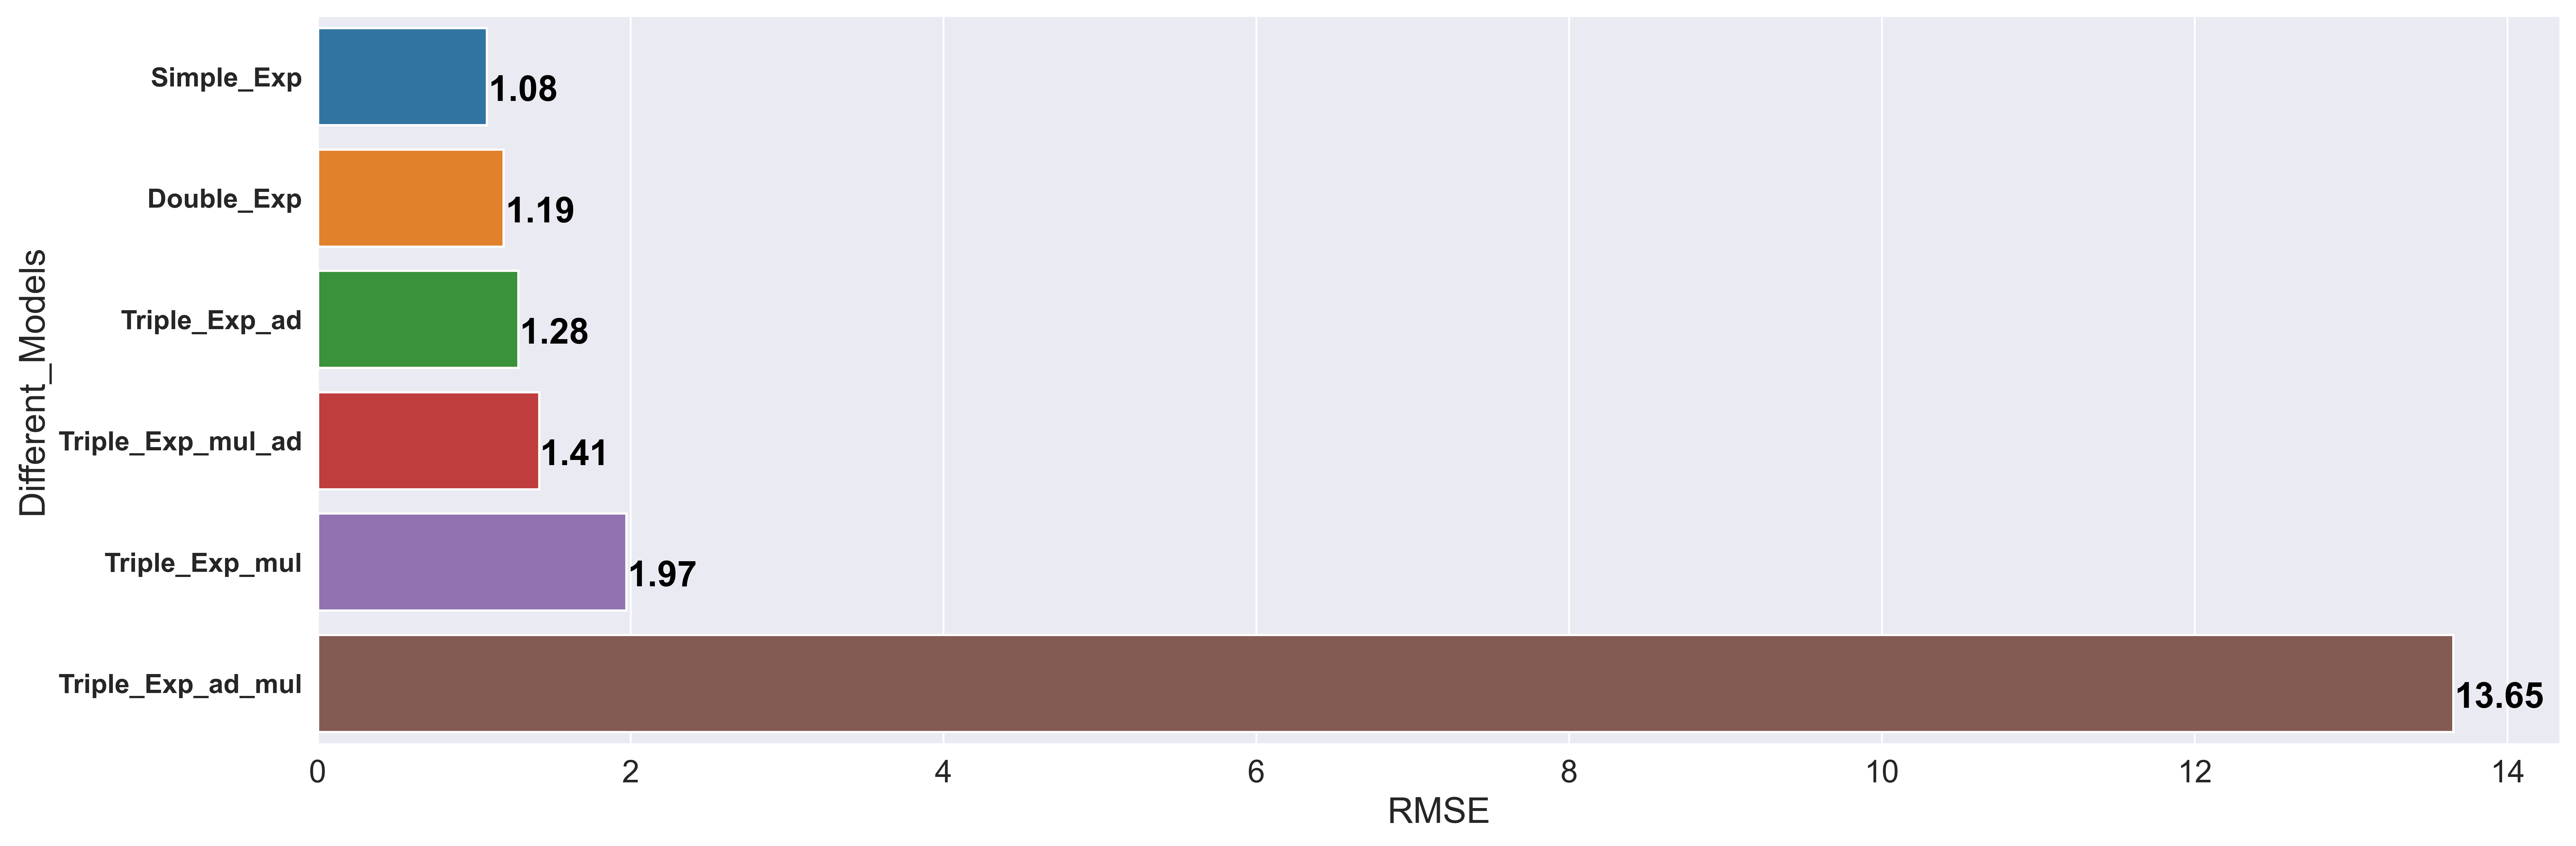

In [27]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,2)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

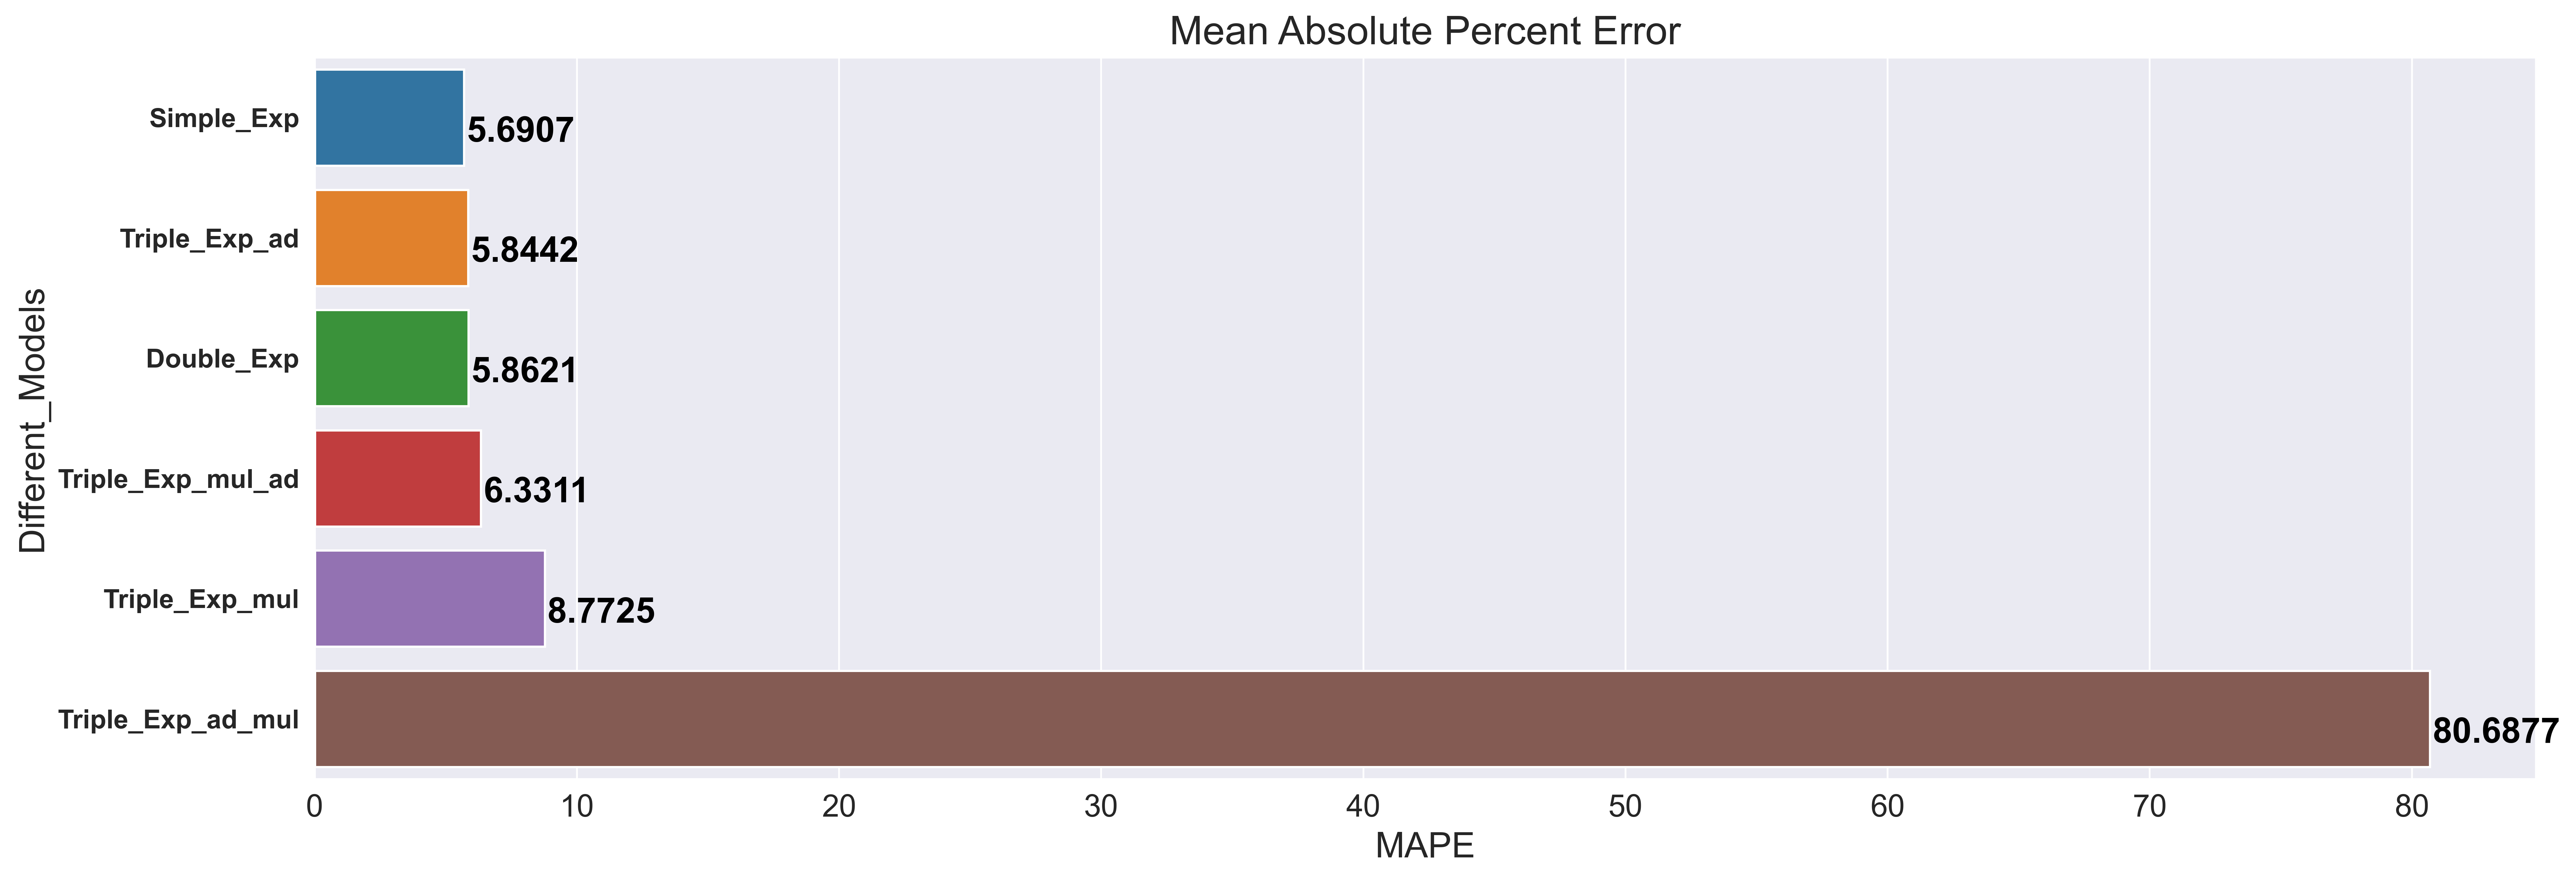

In [28]:
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['Test_MAPE(%)'].values,4)):
    axe.text(v + 0.1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

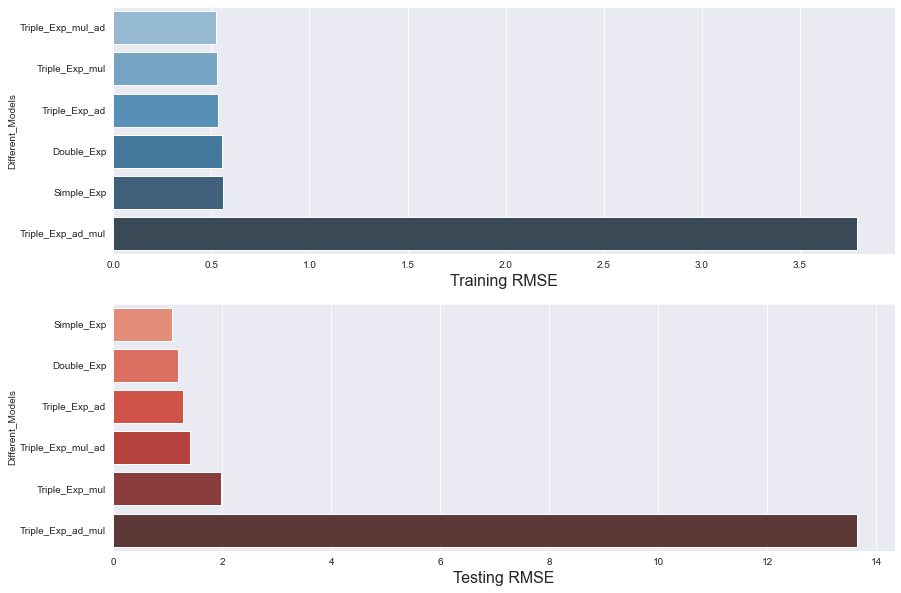

In [29]:
f, axes = plt.subplots(2,1, figsize=(14,10))
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=True)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=True)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

### Assumptions of ARIMA model
1. **Data should be stationary** – by stationary it means that the properties of the series doesn’t depend on the time when it is captured. A white noise series and series with cyclic behavior can also be considered as stationary series.
2. **Data should be univariate** – ARIMA works on a single variable. Auto-regression is all about regression with the past values.

#### Stationary vs Non-stationary Time Series

#### Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

### Test of Stationarity

##### As we have yearly data the window size for moving average is equal to 12

In [80]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(16,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['CO2'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(np.round(dfoutput,3))
    
    result = adfuller(timeseries.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")

### Converting Non-Stationary Time Series into Stationary

#### Differencing
In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:

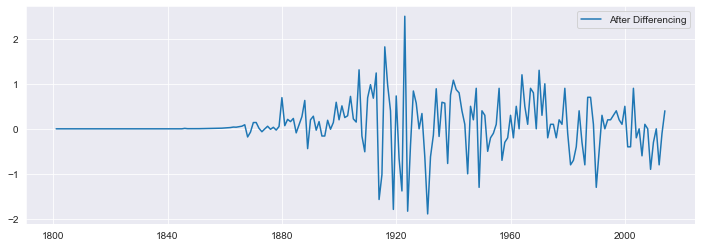

In [78]:
differencing = data - data.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

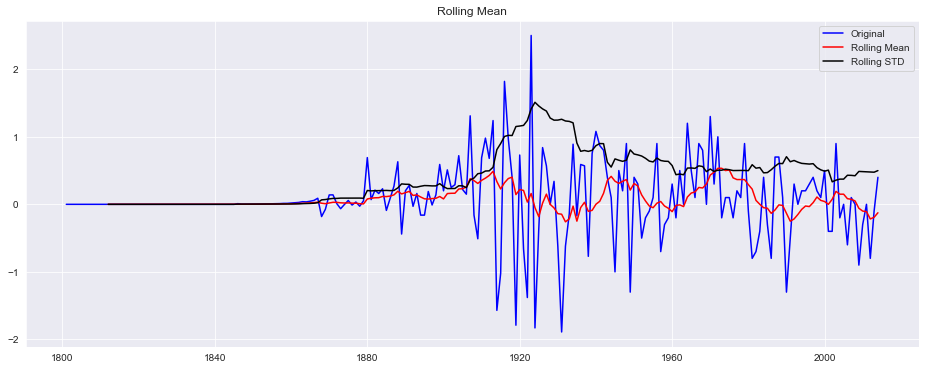

Results of Dickey Fuller Test:
Test Statistic                  -3.780
p-value                          0.003
#Lags Used                      15.000
Number of Observations Used    198.000
Critical Value (1%)             -3.464
Critical Value (5%)             -2.876
Critical Value (10%)            -2.575
dtype: float64
Reject the null hypothesis
Data is stationary


In [81]:
test_stationarity(differencing)

#### ^Observation: Finally our data is stationary and it does not have any trend and seasonality. The data does not depend on the time when it is captured.

##### Finally, Our Time Series is now stationary for AR Forecasting

## ARIMA Hyperparameter Tuning

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [82]:
size = -20
train_data = data[:size]
test_data = data[size:]
train_data_diff = differencing[:size]
test_data_diff = differencing[size:]

In [84]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data_diff, order=pdq).fit()
        pred = model.forecast(20)
        error = np.sqrt(mean_squared_error(test_data_diff,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [85]:
results = pd.DataFrame(index=order,data=rmse,columns=['RMSE'])
results.sort_values('RMSE').head(20)

,RMSE
"(3, 3, 7)",0.413738
"(4, 3, 6)",0.416139
"(2, 4, 6)",0.416213
"(5, 3, 7)",0.417933
"(3, 3, 6)",0.417979
...,...
"(1, 4, 0)",491.538615
"(0, 4, 0)",846.267131
"(0, 4, 0)",846.267131
"(0, 4, 0)",937.120421


In [76]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [77]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

### ARIMA Hyperparameter Tuning using Differencing dataset

In [101]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
evaluate_models(differencing.CO2, p_values, d_values, q_values)

Best ARIMA(3, 1, 0) RMSE=0.432


### ARIMA Hyperparameter Tuning using Original Time series.

In [ ]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
evaluate_models(train_data.values, test_data.values, p_values, d_values, q_values)

In [15]:
import itertools

In [16]:
p = range(0,8)
q = range(0,8)
d = range(0,5)

In [17]:
pqd_combination = list(itertools.product(p,d,q))

In [18]:
len(pqd_combination)

320

In [34]:
rmse = []
order = []

In [35]:
len(test_data)

20

In [36]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data, order=pdq).fit()
        pred = model.forecast(20)
        error = np.sqrt(mean_squared_error(test_data,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [37]:
results = pd.DataFrame(index=order,data=rmse,columns=['RMSE'])
results.sort_values('RMSE').head(20)

,RMSE
"(4, 1, 4)",0.708347
"(0, 4, 2)",0.834664
"(3, 4, 7)",0.913298
"(2, 4, 5)",0.920789
"(2, 4, 6)",0.929380
"(0, 4, 4)",0.931880
"(3, 1, 4)",0.936875
"(2, 4, 7)",0.937776
"(3, 4, 6)",0.943133
"(4, 4, 6)",0.946665


### ^Observation: After using Rawdataset we got the best optimal values

#### Building The Time Series Forecasting with Optimal Value using ARIMA
Automatically performs the Differencing if the series has trend.

Hence, no need to manually perform the differencing.

##### Inverse transformation of the  Differencing 
As we have converted the original time series to Stationary series by consecutively applying BoxCox transformation and Differencing. We have to transform the series back to the original one (step by step).

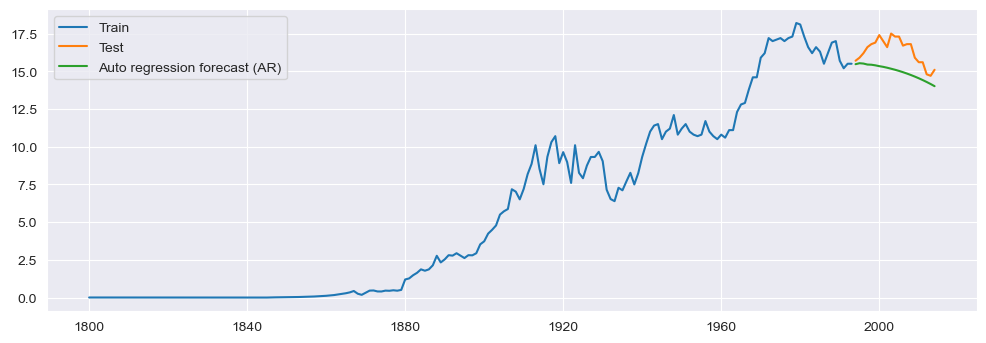

In [108]:
model = ARIMA(train_data_diff, order=(2, 3, 2))
model_fit = model.fit()
y_hat_ar = data.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(differencing.index.min(), differencing.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data.CO2[0])
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [100]:
data.CO2[0]

0.00568

In [15]:
model = ARIMA(train_data, order=(3, 1, 4))
model_fit = model.fit()
y_hat_ar = data.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data.index.min(), data.index.max())

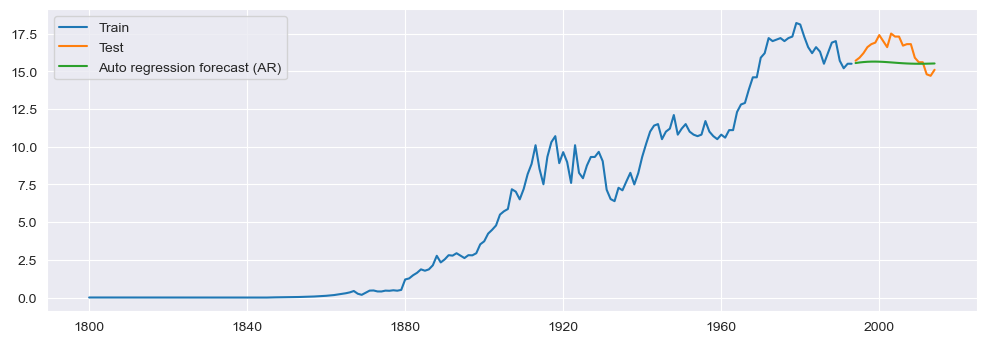

In [22]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [8]:
model = ARIMA(train_data, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data.copy()
pred = model_fit.forecast(20)
y_hat_ar['arima_forecast'] = model_fit.predict(data.index.min(), data.index.max())

In [21]:
%matplotlib inline

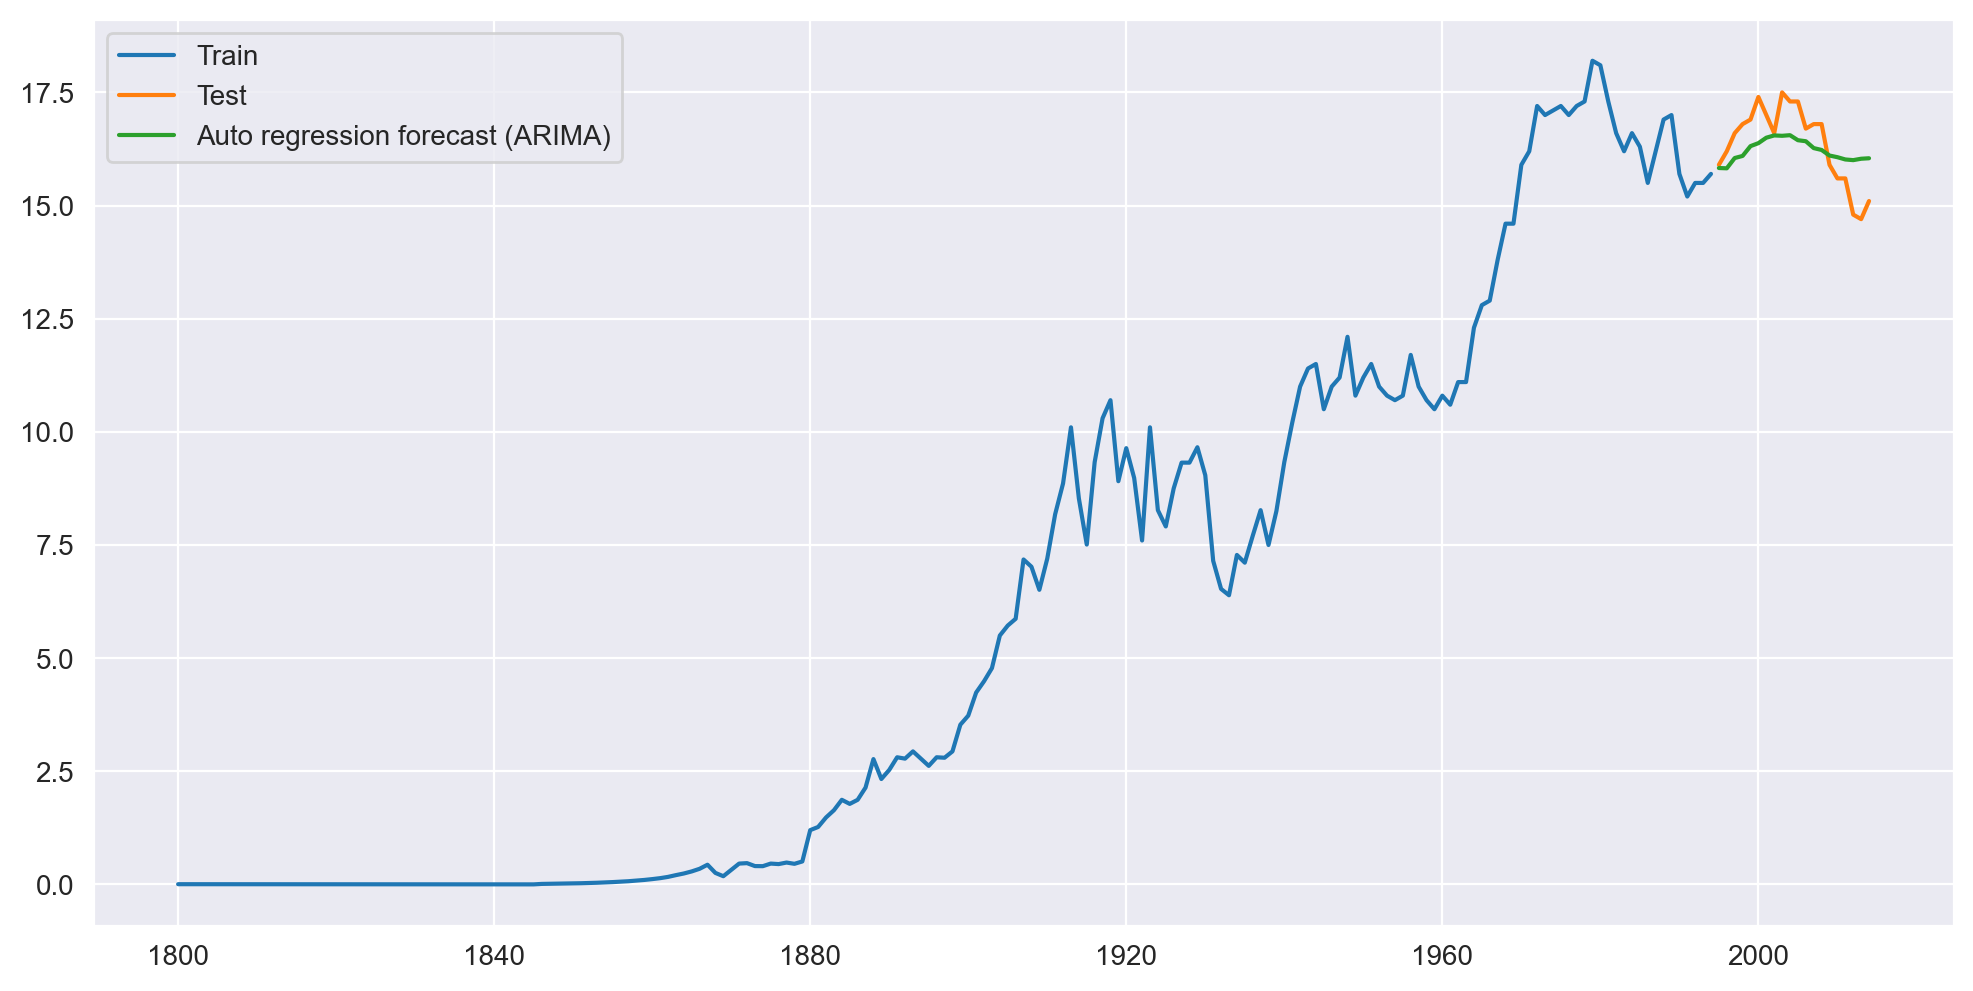

In [22]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

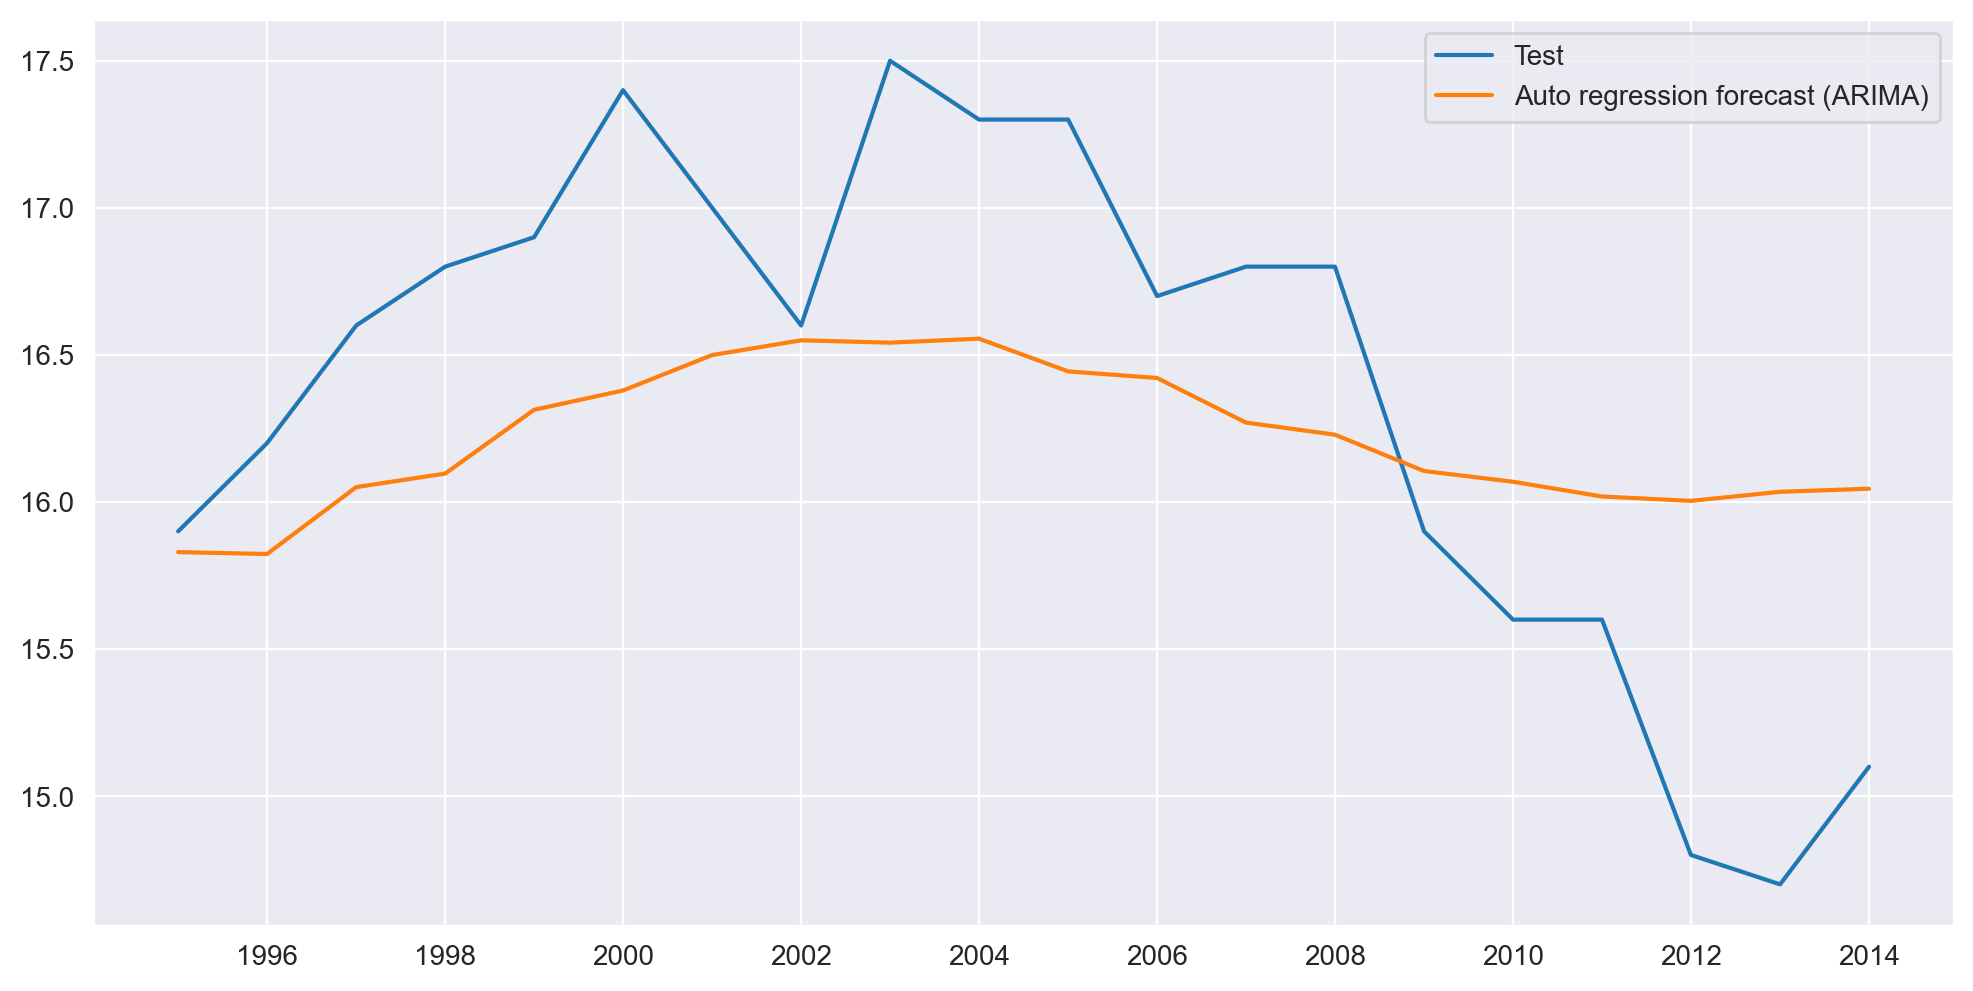

In [23]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [24]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(3)
rmse_ARIMA

0.708

In [45]:
len(test_data)

21

#### MAPE (Mean Absolute Percent Error)

In [25]:
mape_arima = round(np.mean(np.abs((test_data.CO2 - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_arima

3.81

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [26]:
model_residual = model_fit.resid
model_residual.mean()

0.07082672109624973

#### Residuals must be stationary

In [27]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [28]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

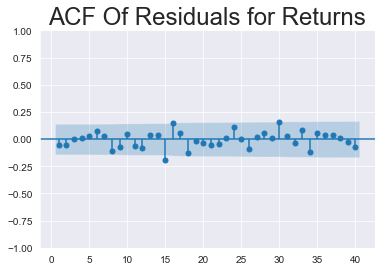

In [29]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

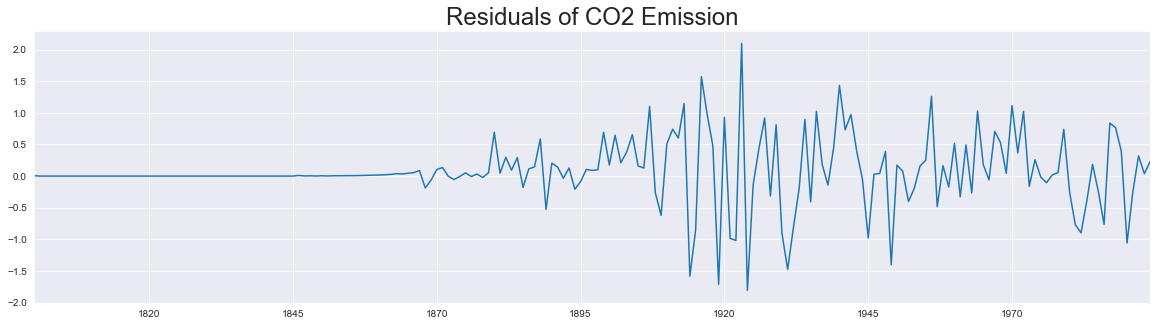

In [30]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of CO2 Emission", size=24)
plt.show()

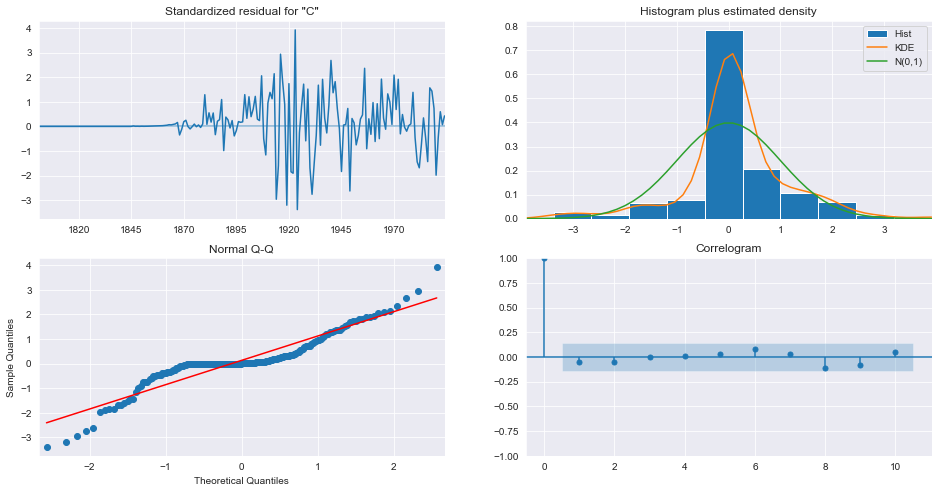

In [31]:
model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

### Calculating Absolute Percent Error and Error<a class="anchor" id="7.3"></a>

In [42]:
# Computing the absolute percent error
APE=100*(abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast'])/y_hat_ar['CO2'])
Error = (abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast']))
print('The Accuracy for Test Data -- ARIMA model = {}%'.format(np.round(100-np.mean(APE.tail(20))),2))
print('The Mean Absolute Error for Test Data -- ARIMA model = ', np.round(np.mean((Error.tail(20))),2))

# adding absolute percent error to table
y_hat_ar['Error']=Error
y_hat_ar['Absolute Percent Error %']=APE

y_hat_ar.tail(20)

The Accuracy for Test Data -- ARIMA model = 96.0%
The Mean Absolute Error for Test Data -- ARIMA model =  0.62


,CO2,arima_forecast,Error,Absolute Percent Error %
1995-01-01,15.9,15.829526,0.070474,0.443230
1996-01-01,16.2,15.823106,0.376894,2.326509
1997-01-01,16.6,16.050471,0.549529,3.310417
1998-01-01,16.8,16.096496,0.703504,4.187524
1999-01-01,16.9,16.313294,0.586706,3.471635
2000-01-01,17.4,16.379003,1.020997,5.867800
2001-01-01,17.0,16.499480,0.500520,2.944233
2002-01-01,16.6,16.549610,0.050390,0.303554
2003-01-01,17.5,16.541561,0.958439,5.476796
2004-01-01,17.3,16.555192,0.744808,4.305247


In [33]:
np.mean(APE.tail(21))

3.70060977435865

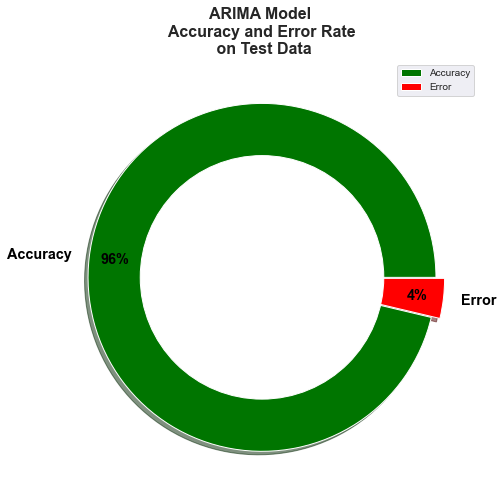

In [47]:
plt.figure(figsize=(12,8)) 
# Setting size in Chart based on 
# given values
Error_Rate = np.mean(APE.tail(21))
Accuracy = 100-np.mean(APE.tail(21))
sizes = [Accuracy, Error_Rate]
  
# Setting labels for items in Chart
labels = ['Accuracy', 'Error']
  
# colors
colors = ['#007500', '#FF0000']
  
# explosion
explode = (0.0, 0.05)
  
# Pie Chart
plt.pie(sizes, colors=colors, labels=labels,
        autopct='%1.0f%%', shadow=True,
        pctdistance=0.85, 
        explode=explode,
        startangle=0,
        textprops = {'size':'x-large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('ARIMA Model \n Accuracy and Error Rate \n on Test Data', fontsize = 16, fontweight = 'bold')
  
# Add Legends
plt.legend(labels, loc="upper right")
  
# Displaying Chart
plt.show()

[Table of Contents](#0.1)

### Visualizing the Relationship between the Actual and Predicted ValuesModel Validation<a class="anchor" id="7.4"></a>

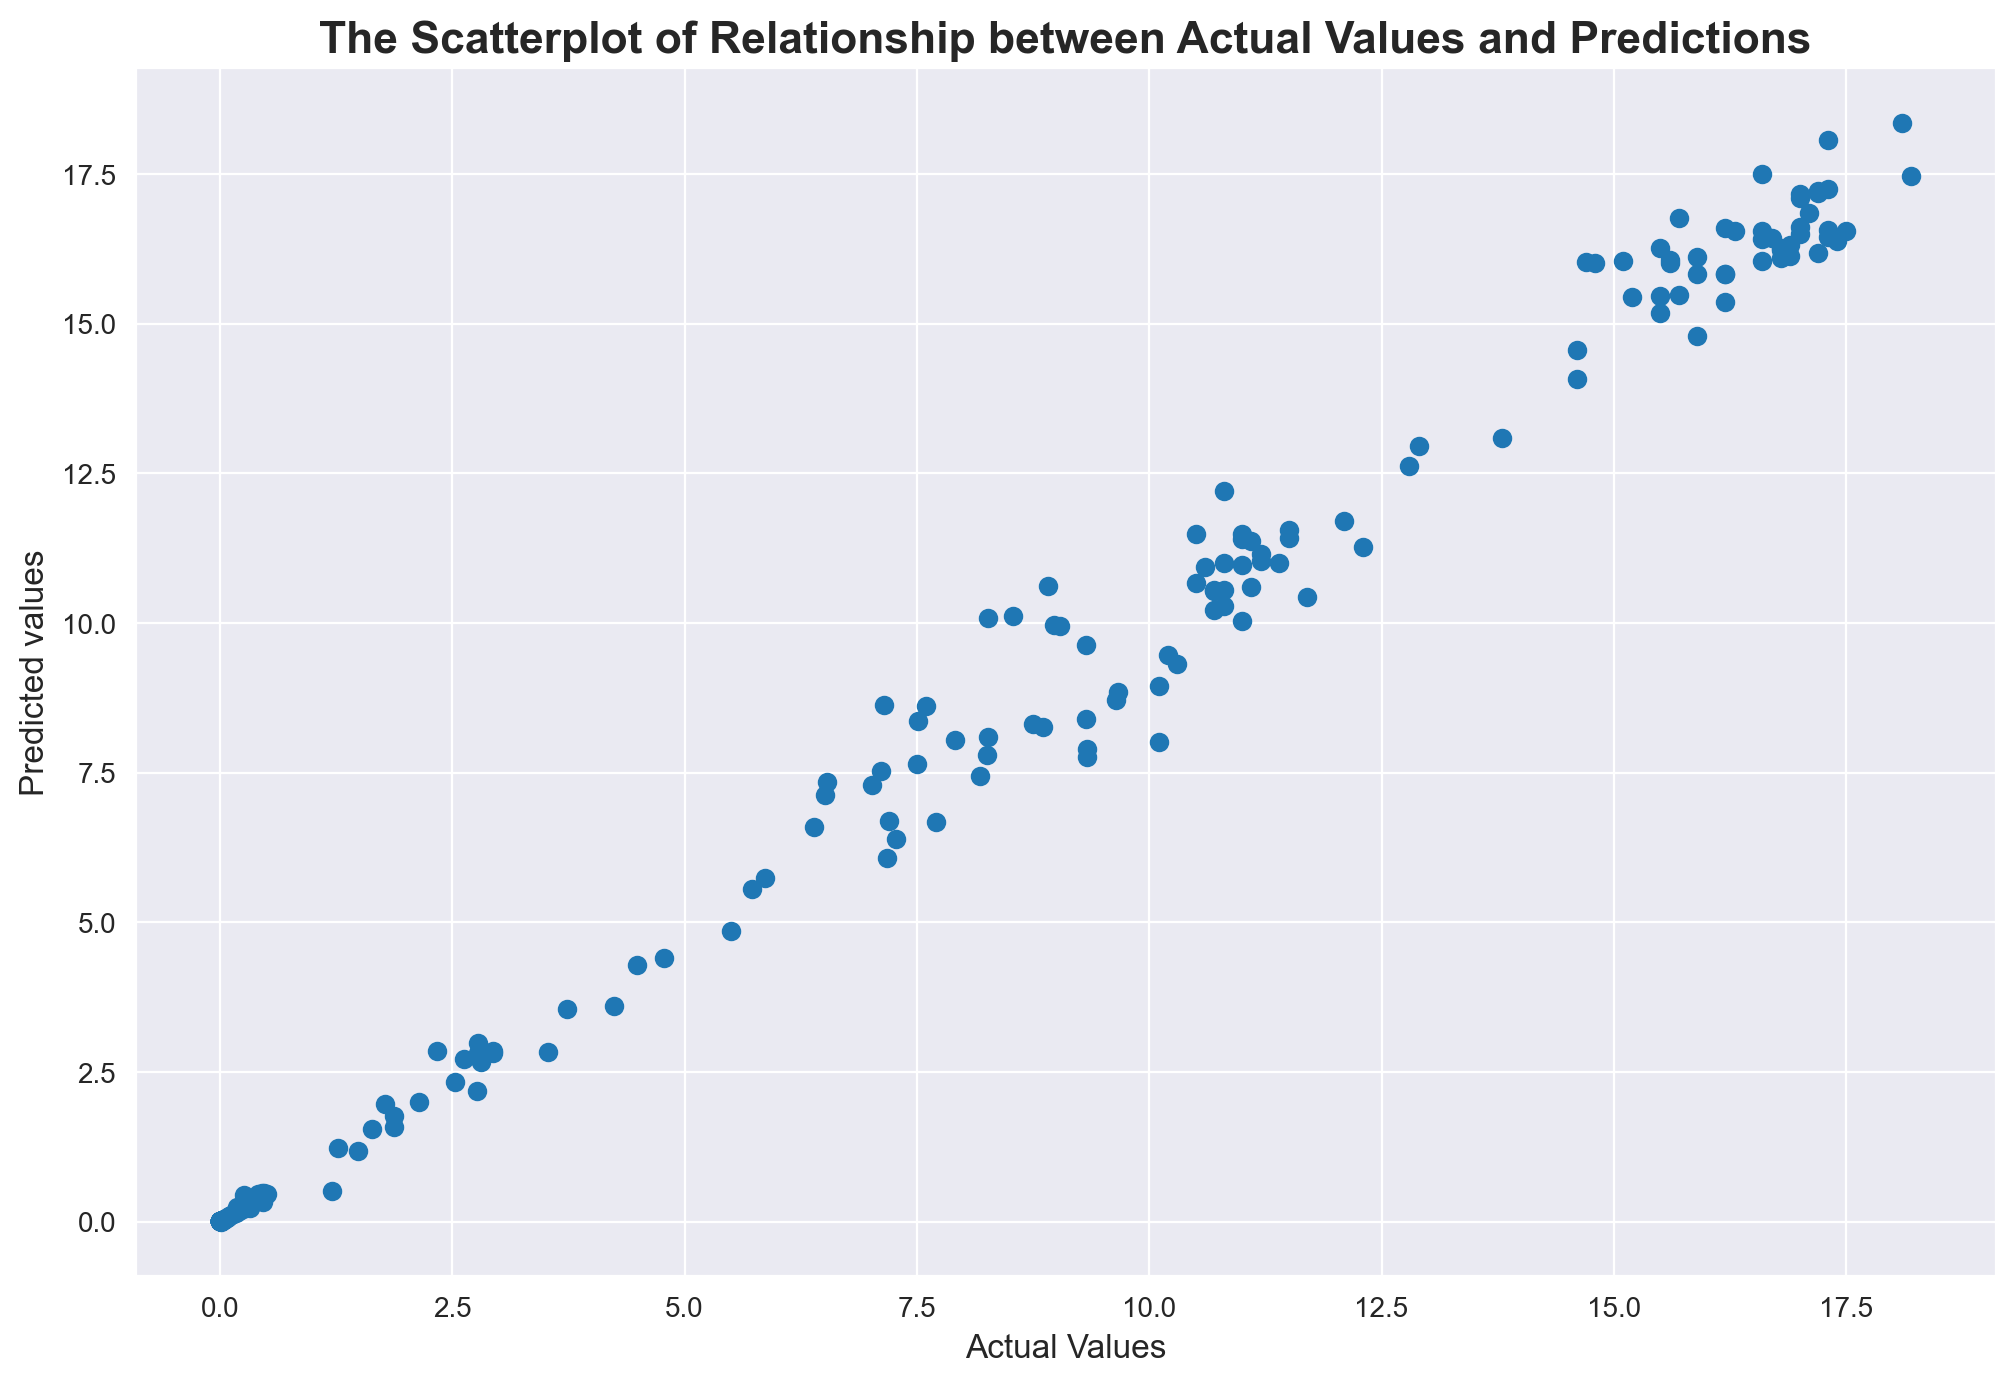

In [35]:
plt.figure(figsize=(12,8), dpi=200)
plt.xlabel("Actual Values", fontsize =12)
plt.ylabel("Predicted values", fontsize =12)
plt.title("The Scatterplot of Relationship between Actual Values and Predictions", fontsize =16, fontweight = 'bold')
plt.scatter(y_hat_ar['CO2'], y_hat_ar['arima_forecast'])
plt.show()

In [48]:
y_hat_ar.to_csv('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/prediction.csv')

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [40]:
model = SARIMAX(train_data, order=(4, 1, 4), seasonal_order=(4, 1, 4,10))
model_fit= model.fit()
y_hat_sarima = data.copy()

#### Inverse Transformation of the Differencing Box-Cox Transformation
Note that ARIMAM automatically takes care of the reversing of `Differencing` (takes care the `Integration` part automatically). So, we don't need to perform the cumsum here. We only have to do the reverse of the log boc cox transformation.

In ARIMA, we had to perform the cumsum manually.

In [44]:
y_hat_sarima['sarima_forecast'] = model_fit.predict(data.index.min(), data.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
#y_hat_sarima['sarima_forecast'] = y_hat_sarima['sarima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
#y_hat_sarima['sarima_forecast'] = y_hat_sarima['sarima_forecast'].add(data.CO2[0])
#y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
#y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

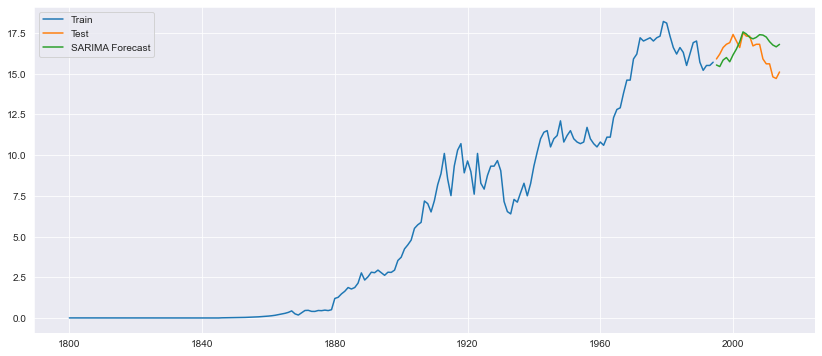

In [45]:
plt.figure(figsize=(14,6), dpi = 200)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

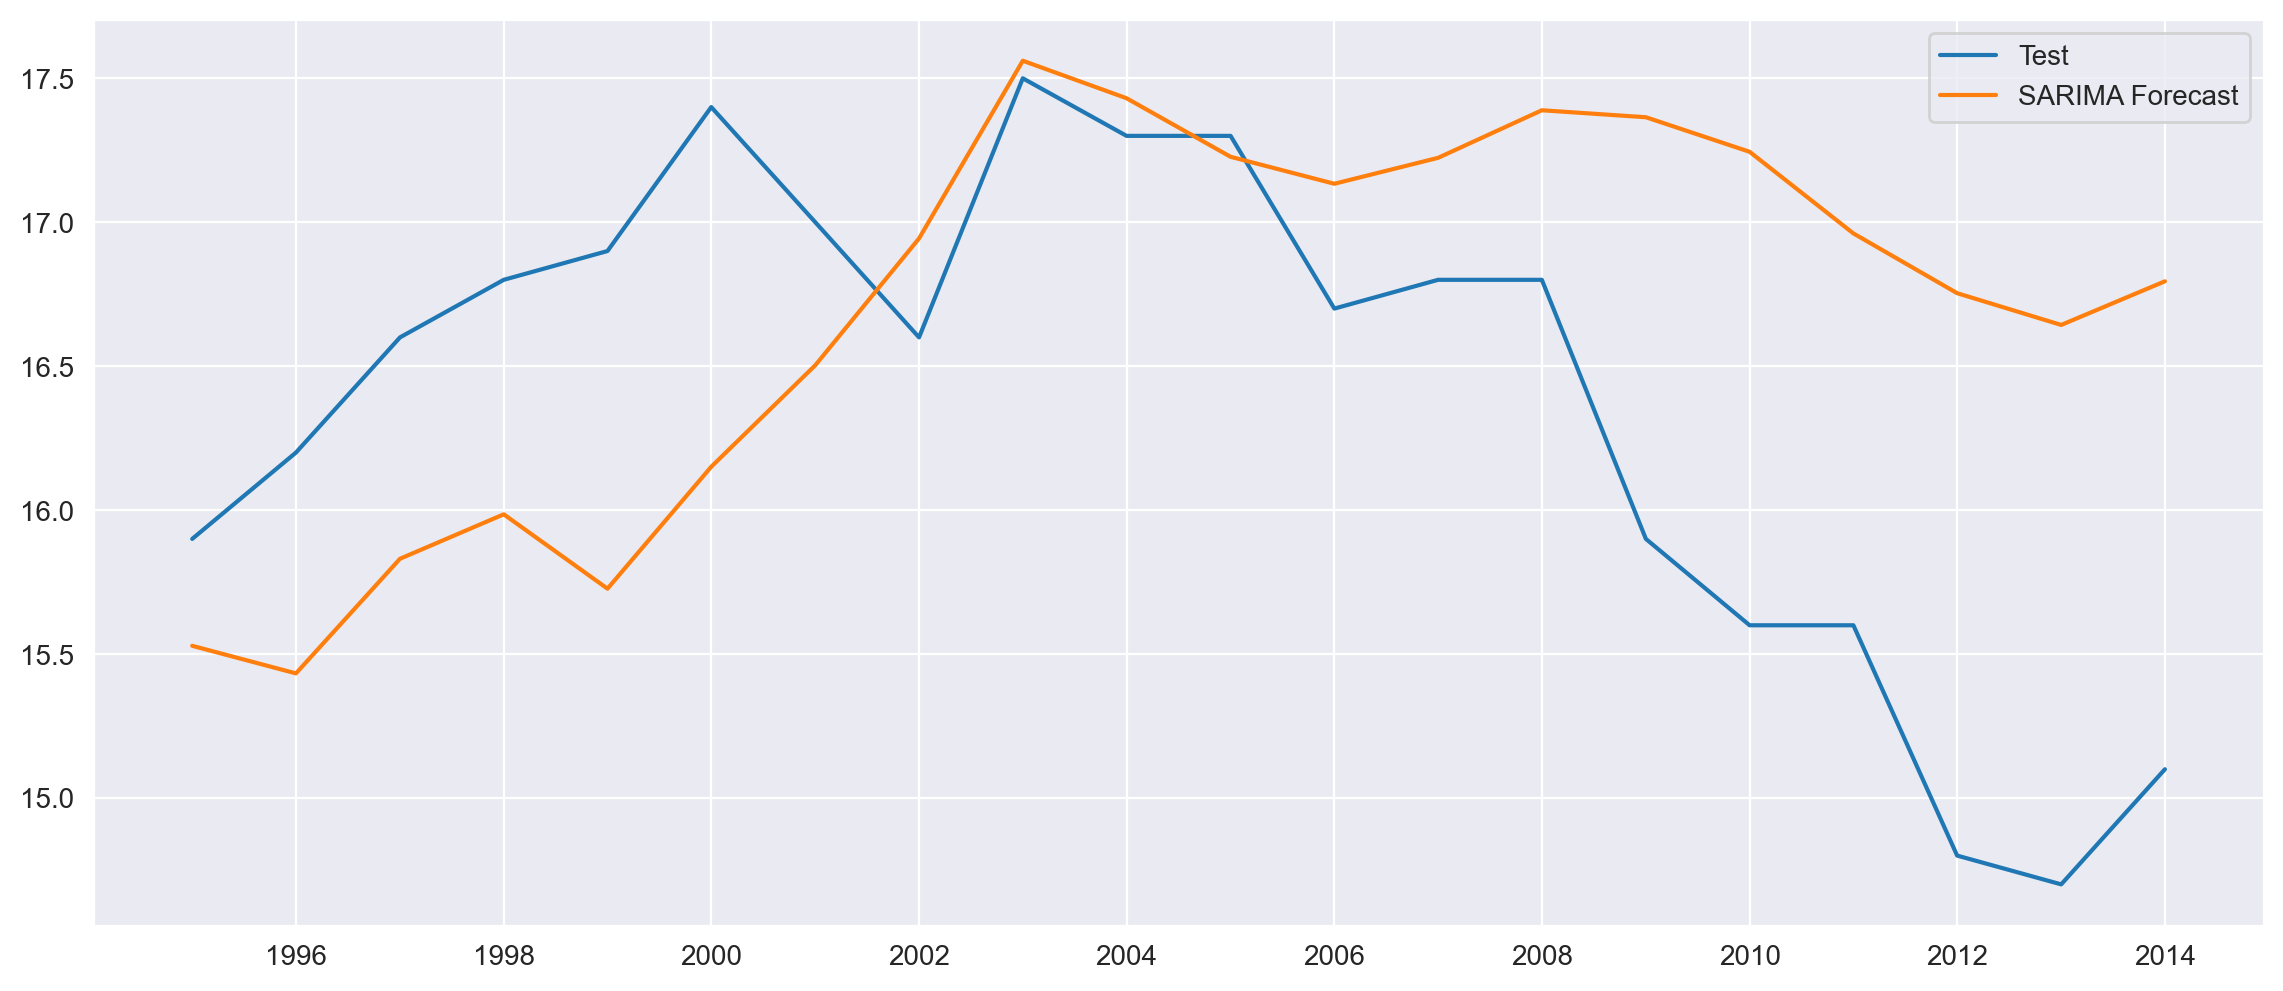

In [46]:
plt.figure(figsize=(14,6), dpi = 200)
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [56]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

1.08

In [132]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

1.45

#### MAPE (Mean Absolute Percent Error)

In [58]:
mape_sarima = round(np.mean(np.abs((test_data.CO2 - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_sarima

5.6

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [59]:
model_residual = model_fit.resid
model_residual.mean()

0.032255634184446755

#### Residuals must be stationary

In [66]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

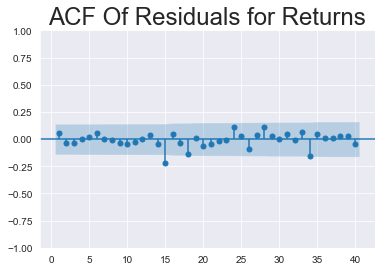

In [67]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

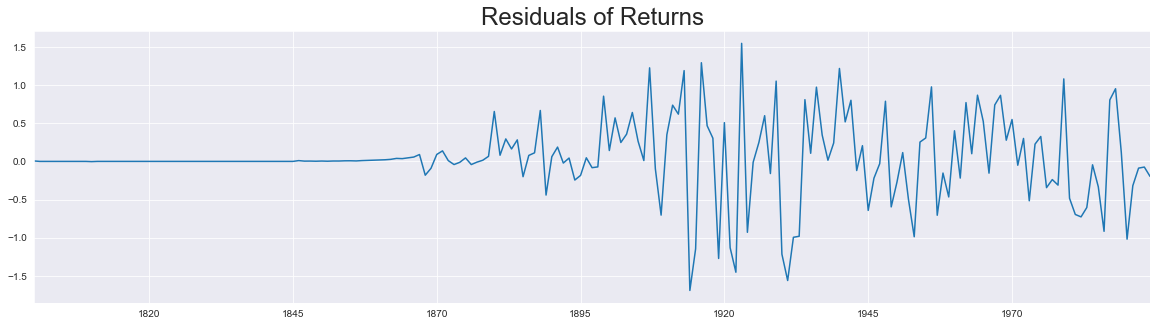

In [68]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [81]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,ARIMA,3.810000,0.710000
1,Simple_Exponential,5.690677,1.079182
2,SARIMA,5.600000,1.080000
3,Double_Exponential,5.862070,1.186728
4,Triple_Exp_additive,5.844243,1.281023
5,Triple_Exp_mul_ad,6.331100,1.414866
6,Triple_Exp_multiplicative,8.772541,1.972891
7,Triple_Exp_ad_mul,80.687656,13.653019


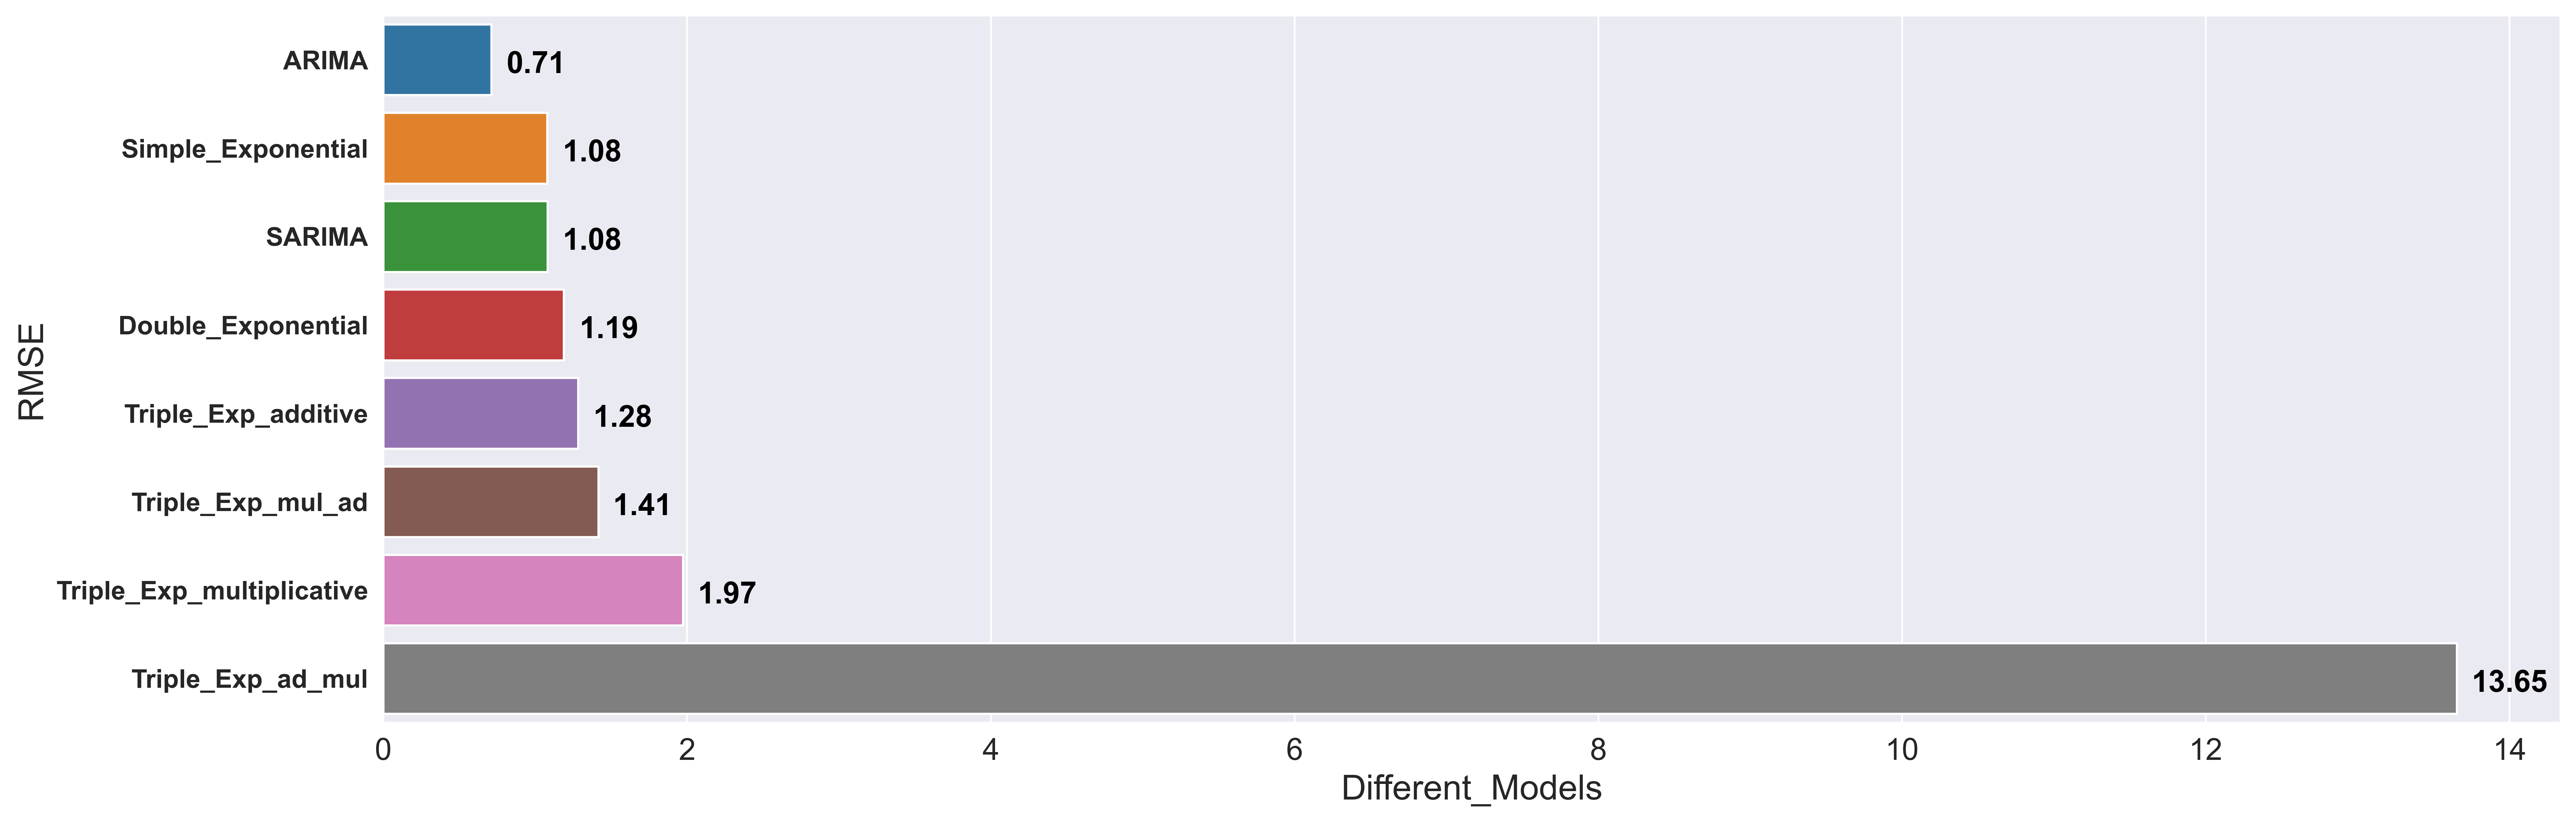

In [82]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,2)):
    axe.text(v + 0.1, i + .15, str(v),
            color = 'black', fontweight = 'bold', fontsize= 14)

plt.show()

#### Observation:
+ **The Sarima Model did not performed very well as compared to other Models but Simple Exponential Smoothing better** 
+ **Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in models such as ARIMA wiht hyperparameter tuning gave the best restult in this case**

#### Conclusion:
## <p style="color:black;font-size:18;">ARIMA:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

### Forecasting Future Values Using ARIMA Model

#### Forecasting 5 years of data using the complete Data set

In [7]:
%matplotlib inline

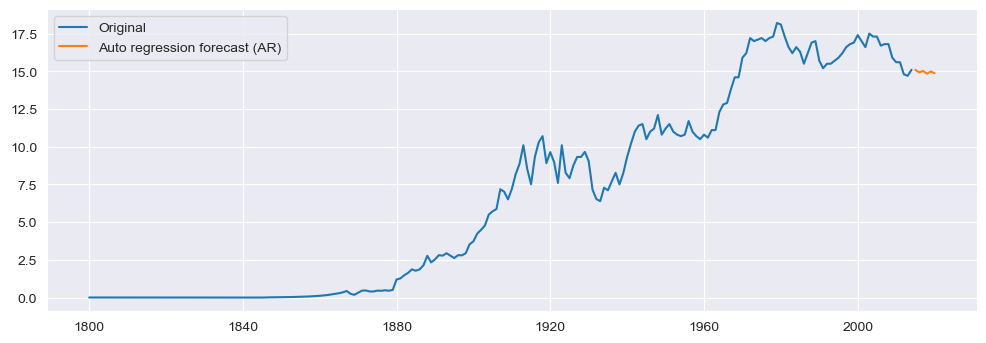

In [14]:
final_arima = ARIMA(data, order=(4, 1, 4))
final_arima_fit = final_arima.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_arima_fit.predict(start = 215, end = 220)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

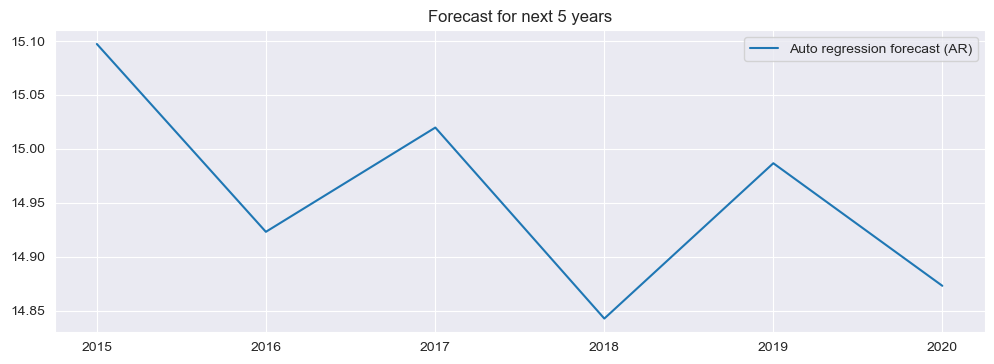

In [15]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 5 years')
plt.legend(loc='best')
plt.show()

In [91]:
forecast

,arima_forecast
2015-01-01,15.097144
2016-01-01,14.922983
2017-01-01,15.019669
2018-01-01,14.842564
2019-01-01,14.986585
2020-01-01,14.872921


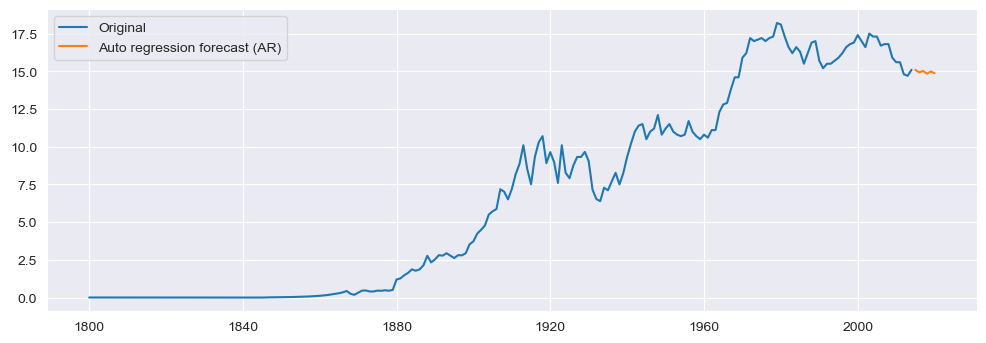

In [16]:
forecast['arima_forecast'] = final_arima_fit.predict(start = 215, end = 225)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

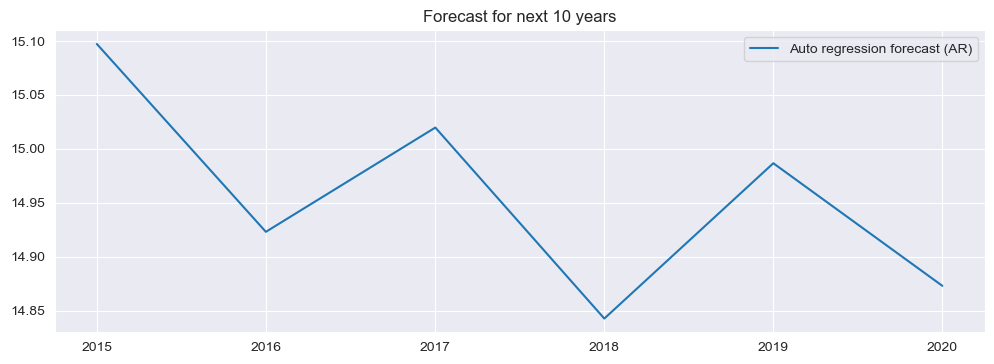

In [17]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 10 years')
plt.legend(loc='best')
plt.show()

In [51]:
forecast

,arima_forecast
2015-01-01,15.097144
2016-01-01,14.922983
2017-01-01,15.019669
2018-01-01,14.842564
2019-01-01,14.986585
2020-01-01,14.872921
2021-01-01,15.004503
2022-01-01,14.982283
2023-01-01,15.056656
2024-01-01,15.113576


In [18]:
# Saving the pickle file
import pickle
pickle.dump(final_arima_fit, open('CO2_Forecast_arima.pkl','wb'))

In [9]:
# Saving the pickle file
import pickle
pickle.dump(model_fit, open('yearly_train_arima.pkl','wb'))

## Links for the repositories

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:#000000;
            border-style: false;
            border-width: 2px;
            color:#CF673A;
            font-size:15px;
            font-family: Georgia;
            background-color:#E8DCCC;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>♡ Thank you for taking the time ♡**